In [1]:
# This is the template for the submission. If you want, you can develop your algorithm in a regular Python script and copy the code here for submission.

# Team members (e-mail, legi):
# zhisun@ethz.ch, 22-958-227
# enjcao@ethz.ch, 22-942-700
# yifzhou@ethz.ch, 22-940-381

In [14]:
import pandas as pd

from Lilygo.Recording import Recording
from Lilygo.Dataset import Dataset
from os import listdir
from os.path import isfile, join
from math import sqrt
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt


In [6]:
# Get the path of all traces
dir_traces = './data/traces'
filenames = [join(dir_traces, f) for f in listdir(dir_traces) if isfile(join(dir_traces, f))]
filenames.sort()
print(filenames)

['./data/traces/trace_01.json', './data/traces/trace_02.json', './data/traces/trace_03.json', './data/traces/trace_04.json', './data/traces/trace_05.json', './data/traces/trace_06.json', './data/traces/trace_07.json', './data/traces/trace_08.json', './data/traces/trace_09.json', './data/traces/trace_10.json']


In [7]:
# mean filter signal with window size N
def mean_filter(signal, N):
    filter_signal = np.zeros((len(signal),))
    for ctr in range(len(signal)):
         filter_signal[ctr] = np.sum(signal[ctr:(ctr+N)])
    return filter_signal/N

In [8]:
# get minimum height for peak
def get_peak_height(signal):
    
    height = 0
    return height

In [9]:
def get_peaks(signal, min_peak_height):
    peak_locations, _ = sp.signal.find_peaks(signal, height=min_peak_height)
    peak_values = signal[peak_locations]
    return peak_locations, peak_values

In [ ]:
# # Remove outliers
# # Z score
# def get_outliers(signal,z_threshold,timestamps, min_peak_height):
#     # return arrays 'outlier_locations','outlier_values' with the same size as 'peaks_locations'/'peaks_values', 
#     # The values and locations of oulier peaks in 'peaks_locations'/'peaks_values' are kept 
#     # And those of non-oulier peaks are set to 0
    
#     peak_locations, peak_values = get_peaks(signal, min_peak_height)
# #     valley_locations, minus_valley_values = get_peaks(-signal, min_peak_height)
  
#     z = np.abs(sp.stats.zscore(peak_values))
#     compare = np.zeros_like(peak_locations)
#     for i in range(len(z)):   
#         if z[i] > z_threshold:
#             compare[i] = 1
#     # compare: an array with 0 or 1 for found peak in denoised data, where 1 represents peak outliers at corresponding index
    
#     outlier_locations = np.multiply(peak_locations,compare)
#     outlier_values = np.multiply(peak_values,compare)
#     print('compare:',compare,'\n outlier locations:',outlier_locations,'\n peak locations:',peak_locations,'\n outlier values:',outlier_values,'\n peak values:',peak_values)
#     return z,outlier_locations,outlier_values, peak_locations, peak_values

In [17]:
# Remove outliers
# Z score
def get_outliers(signal,z_threshold,timestamps, min_peak_height):
    # return arrays 'outlier_locations','outlier_values' with the same size as 'peaks_locations'/'peaks_values', 
    # The values and locations of oulier peaks in 'peaks_locations'/'peaks_values' are kept 
    # And those of non-oulier peaks are set to 0
    
    peak_locations, peak_values = get_peaks(signal, min_peak_height)
#     valley_locations, minus_valley_values = get_peaks(-signal, min_peak_height)
  
    z = np.abs(sp.stats.zscore(signal))
    compare = np.zeros_like(timestamps)
    for i in range(len(z)):   
        if z[i] > z_threshold:
            compare[i] = 1
    # compare: an array with 0 or 1 for found peak in denoised data, where 1 represents peak outliers at corresponding index
    
    outlier_locations = np.multiply(timestamps, compare)
    outlier_values = np.multiply(signal, compare)
#     print('compare:',compare,'\n outlier locations:',outlier_locations,'\n peak locations:',peak_locations,'\n outlier values:',outlier_values,'\n peak values:',peak_values)
    return outlier_locations,outlier_values

In [11]:
def normalize(signal, min_peak_height, z_threshold, valley_values):
    #find maximum among all peak values except oulier peaks
    peak_locations, peak_values = get_peaks(signal, min_peak_height)
    outlier_locations,outlier_values = get_outliers(signal,z_threshold)
    max_candidates =  peak_values-outlier_values
    mx=np.max(max_candidates)
    
    #find minimum all valley values except oulier valleys
    peak_locations, peak_values = get_peaks(-signal, min_peak_height)
    voutlier_locations,voutlier_values = get_outliers(-signal,z_threshold)
    min_candidates = valley_values-voutlier_values
    mn=-np.max(min_candidates)
    
    #normalize signal 
    normalized_signal = np.true_divide((signal-mn),(mx-mn),out=np.zeros_like(signal),where=(mx-mn)!=0)
    
    return normalized_signal

In [12]:
def baseline_removal(normalized_signal,winsize):
    # Apply moving average filter on normalized signal to find baseline
    baseline = np.convolve(normalized_signal, np.ones((winsize,))/winsize, mode='valid')
    # Remove baseline from normalized signal to get aligned_signal
    aligned_signal = normalized_signal - baseline
    return baseline,aligned_signal


In [ ]:
# # peak detection
# def get_peaks(signal, timestamps, min_peak_height):
#     peak_locations = []
#     peak_values = []
#     min_distance_between_peaks_ms = 200
    
#     last_peak_timestamp = -1
#     for i in range(9, len(signal) - 10):
#             forward_slope = signal[i + 10] - signal[i]
#             backward_slope = signal[i] - signal[i - 10]
#             if forward_slope < 0 and backward_slope > 0:
# #                 if len(peak_locations) > 0:
# #                     peak_diff = np.abs(signal[i] - peak_locations[-1])
                    
# #                     if peak_diff < 0.5:
# #                         peak_index = i
# #                         peak_val = signal[i]
# #                 else:
#                 peak_index = i
#                 peak_val = signal[i]
#                 #print("Found peak at index={} with val={}".format(peak_index, peak_val))
#                 if(peak_val >= min_peak_height):
#                     # print("Peak at index={} passes minimum height value ({})".format(peak_index, min_peak_height))
#                     time_since_last_detection_ms = timestamps[peak_index] - last_peak_timestamp
#                     if(last_peak_timestamp == -1 or time_since_last_detection_ms >= min_distance_between_peaks_ms):
#                         last_peak_timestamp = timestamps[peak_index]
#                         peak_locations.append(peak_index)
#                         peak_values.append(peak_val)
            
#     return peak_locations, peak_values


ValueError: operands could not be broadcast together with shapes (12798,) (12832,) 

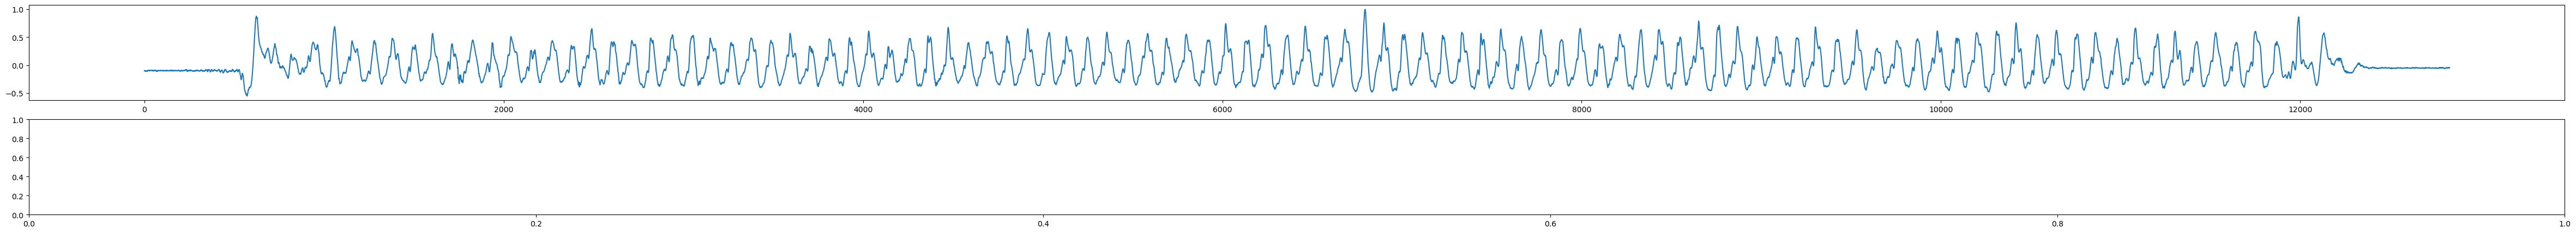

In [16]:
stepCounts = []
ids = []
# for filename in filenames:
filename = filenames[4]
trace = Recording(filename, no_labels=True, mute=True)
stepCount = 0

# Your algorithm goes here
# Make sure, you only use data from the LilyGo Wristband, namely the following 10 keys (as in trace.data[key]):
# 3-axis accelerometer: key in [ax, ay, az]
# 3-axis gyro: key in [gx, gy, gz]
# 3-axis magnetometer: key in [mx, my, mz]
# IMU temperature: key==temperature
#
trace = Recording(filename, no_labels=True, mute=True)
ax = trace.data['ax']
ay = trace.data['ay']
az = trace.data['az']
timestamp_raw = ax.timestamps
timestamp_ms = timestamp_raw*1000
sampling_rate = len(timestamp_raw)/timestamp_raw[-1]

# Trace must contain lilygo accelerometer data
assert('ax' in trace.data and 'ay' in trace.data and 'az' in trace.data)
# And those traces must be of the same length
assert(len(ax.values) == len(ay.values)  and len(ax.values) == len(az.values) )
# Calculate raw magnitude of accelerometer signal
amagn = [sqrt(a**2+ay.values[i]**2+az.values[i]**2)for i, a in enumerate(ax.values)]
trace.data['amagn'] = Dataset.fromLists('Accelerometer magnitude', amagn, timestamp_ms)
# trace.plot(['amagn'])


mag_detrended = sp.signal.detrend(amagn)
trace.data['amagn_detrended'] = Dataset.fromLists('Detrended Accelerometer magnitude', mag_detrended, trace.data['ax'].timestamps)
# trace.plot(['amagn_detrended'])
fig, axes = plt.subplots(2,1, figsize=(60, 5)) #figsize is width, height
axes[0].plot(mag_detrended, alpha=1, label="Raw mag")



# Smoothing the signal

# Denoise with convolution
filter_window_size = 35
mag_convolve = np.convolve(mag_detrended, np.ones((filter_window_size,))/filter_window_size, mode='valid')

# Outliers
z_threshold = 1
z,outlier_locations,outlier_values, peak_locations, peak_values = get_outliers(mag_convolve,z_threshold,timestamp_ms, 0)
print(z)

axes[1].plot(mag_convolve, alpha=1, label="smoothed")


axes[1].plot(peak_locations, peak_values, '+', color="yellow", label="Peak Locations")
axes[1].plot(outlier_locations, outlier_values, '+', color="red", label="Peak Locations")

In [ ]:
# print detected peak
fig, axes1 = plt.subplots(1, figsize=(60, 5)) #figsize is width, height
axes1.plot(mag_lowpass_filter, alpha=1, label="Filtered mag")
axes1.axhline(y=min_peak_height, linewidth=1, linestyle=":", alpha=0.6, color='gray')
axes1.plot(peak_locations, mag_lowpass_filter[peak_locations], 'y+', color="red", label="Peak Locations")

stepCount = len(peak_locations)
print(stepCount)

# Append your calculated step counts and the id of the trace to the corresponding array
stepCounts.append(stepCount)
ids.append(filename.split('_')[1][:2])

TypeError: float() argument must be a string or a real number, not 'module'

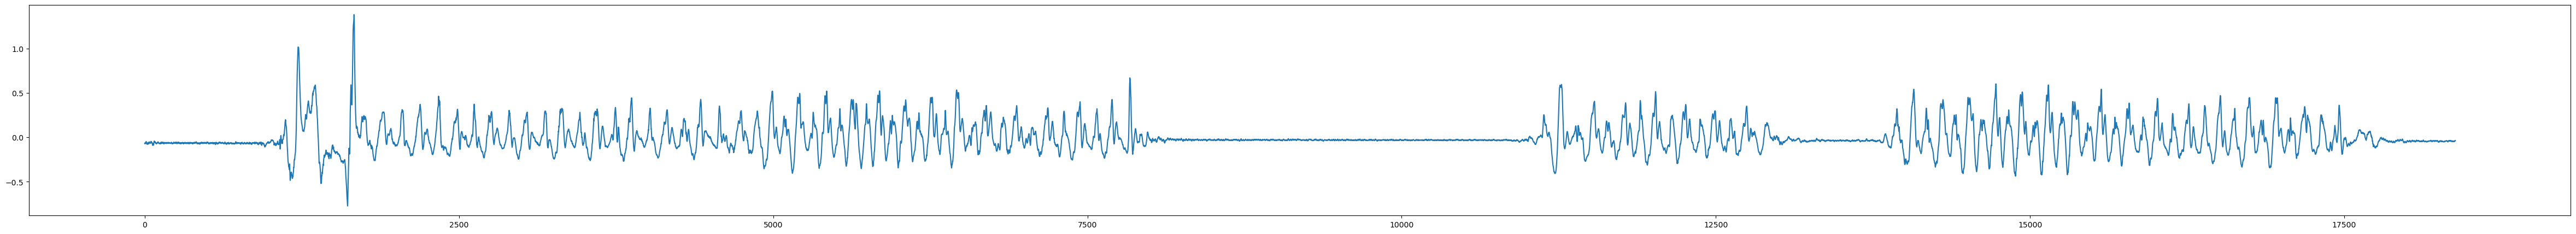

In [15]:
# Loop through all traces and calculate the step count for each trace
stepCounts = []
ids = []
# for filename in filenames:
filename = filenames[3]
trace = Recording(filename, no_labels=True, mute=True)
stepCount = 0  # This is your variable of the step counting that you need to change
#     print(filename)

#
# Your algorithm goes here
# Make sure, you only use data from the LilyGo Wristband, namely the following 10 keys (as in trace.data[key]):
# 3-axis accelerometer: key in [ax, ay, az]
# 3-axis gyro: key in [gx, gy, gz]
# 3-axis magnetometer: key in [mx, my, mz]
# IMU temperature: key==temperature
#
trace = Recording(filename, no_labels=True, mute=True)
ax = trace.data['ax']
ay = trace.data['ay']
az = trace.data['az']
timestamp_raw = ax.timestamps
timestamp_ms = timestamp_raw*1000
sampling_rate = len(timestamp_raw)/timestamp_raw[-1]


# Trace must contain lilygo accelerometer data
assert('ax' in trace.data and 'ay' in trace.data and 'az' in trace.data)
# And those traces must be of the same length
assert(len(ax.values) == len(ay.values)  and len(ax.values) == len(az.values) )
# Calculate raw magnitude of accelerometer signal
amagn = [sqrt(a**2+ay.values[i]**2+az.values[i]**2)for i, a in enumerate(ax.values)]
trace.data['amagn'] = Dataset.fromLists('Accelerometer magnitude', amagn, timestamp_ms)
# trace.plot(['amagn'])


mag_detrended = signal.detrend(amagn)
trace.data['amagn_detrended'] = Dataset.fromLists('Detrended Accelerometer magnitude', mag_detrended, trace.data['ax'].timestamps)
# trace.plot(['amagn_detrended'])

fig, axes = plt.subplots(1, figsize=(60, 5)) #figsize is width, height
axes.plot(mag_detrended, alpha=1, label="Raw mag")

# Smooth signal 

# Convolution
filter_window_size = 35

mag_mean_convolve = np.convolve(mag_detrended, np.ones((filter_window_size,))/filter_window_size, mode='valid')


# low pass filter
filter_order = 1
low_pass_cutoff_freq = 3; #2
sos = sp.signal.butter(filter_order, low_pass_cutoff_freq, 'lowpass', fs=sampling_rate, output='sos')
mag_lowpass_filter = sp.signal.sosfilt(sos, mag_mean_convolve)
# trace.data['amagn_filtered1'] = Dataset.fromLists('Filtered Accelerometer magnitude', mag_butter_filter, timestamp_ms)

# # high pass filter
# high_pass_cutoff_freq = 2.5; 
# sos = sp.signal.butter(filter_order, high_pass_cutoff_freq, 'highpass', fs=sampling_rate, output='sos')
# mag_highpass_filter = sp.signal.sosfilt(sos, mag_lowpass_filter)



# peak detection for step count

# peak_locations_all = get_peak_locations(mag_mean_filter, timestamp_ms, 0)
# peak_val_all = []
# for i in peak_locations_all:
#     peak_val_all.append(mag_mean_filter[i])
# min_peak_height = np.average(peak_val_all)
min_peak_height = 0.05#np.max(mag_butter_filter)/3
# peak_locations = get_peak_locations(mag_butter_filter, timestamp_ms, min_peak_height)
# peak_locations = AMPD(mag_butter_filter)
peak_locations, peak_values = get_peaks(signal, min_peak_height)





# print detected peak
fig, axes1 = plt.subplots(1, figsize=(60, 5)) #figsize is width, height
axes1.plot(mag_lowpass_filter, alpha=1, label="Filtered mag")
axes1.axhline(y=min_peak_height, linewidth=1, linestyle=":", alpha=0.6, color='gray')
axes1.plot(peak_locations, mag_lowpass_filter[peak_locations], 'y+', color="red", label="Peak Locations")

stepCount = len(peak_locations)
print(stepCount)

# Append your calculated step counts and the id of the trace to the corresponding array
stepCounts.append(stepCount)
ids.append(filename.split('_')[1][:2])

In [ ]:
# Write the detected step counts into a .csv file to then upload the .csv file to Kaggle
# When cross-checking the .csv file on your computer, we recommend using the text editor and NOT excel so that the results are displayed correctly
# IMPORTANT: Do NOT change the name of the columns ('Id' and 'Predicted') of the .csv file
df = pd.DataFrame({'Id':ids,'Predicted':stepCounts})
df.to_csv('/kaggle/working/submission.csv', index=False)